In [12]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import f_oneway, kruskal
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.distributions.empirical_distribution import ECDF

## Load in Data

In [13]:
raw_data = pd.read_excel('steriod_study_data.xlsx')

## Clean Data

In [14]:
data = raw_data.iloc[0:22,:14]

In [15]:
data

,ID,group,gdf15_before,gdf15_after,help_before,help_after,puqe_before,puqe_after,gdf15_change,help_change,puqe_change,help_reduction,puqe_reduction,gdf15_percent_change
0,K37,Steroid,8.625892,6.608038,38,10,10,3,-2.017855,-28,-7.0,28,7,-23.392997
1,L14,Steroid,22.974399,24.424706,30,29,11,9,1.450307,-1,-2.0,1,2,6.312710
2,L23,Steroid,23.262108,21.79778,40,21,15,10,-1.464328,-19,-5.0,19,5,-6.294906
3,L37,Steroid,6.889565,12.498578,30,17,12,9,5.609013,-13,-3.0,13,3,81.413157
4,M35,Steroid,14.082705,10.614804,37,31,14,12,-3.467901,-6,-2.0,6,2,-24.625249
5,N2,Steroid,8.569502,6.617576,55,21,15,7,-1.951926,-34,-8.0,34,8,-22.777590
6,P5,Steroid,20.255376,16.678638,42,14,8,4,-3.576739,-28,-4.0,28,4,-17.658219
7,H10,Steroid,19.398124,16.526182,43,11,14,4,-2.871942,-32,-10.0,32,10,-14.805256
8,H1,Steroid,12.664902,10.569372,28,9,11,4,-2.09553,-19,-7.0,19,7,-16.545963
9,H3,Steroid,11.817524,10.433036,34,12,12,6,-1.384488,-22,-6.0,22,6,-11.715551


In [24]:
# Update column data types
data_update = data.astype({'gdf15_before':float, 'gdf15_after':float, 'help_before':float, 'help_after':float, 'puqe_before':float,
                    'puqe_after':float, 'gdf15_change':float, 'help_change':float, 'puqe_change':float, 'help_reduction':float, 
                     'puqe_reduction':float, 'gdf15_percent_change':float})


In [25]:
data_update.dtypes

ID                       object
group                    object
gdf15_before            float64
gdf15_after             float64
help_before             float64
help_after              float64
puqe_before             float64
puqe_after              float64
gdf15_change            float64
help_change             float64
puqe_change             float64
help_reduction          float64
puqe_reduction          float64
gdf15_percent_change    float64
dtype: object

## Boxplots and Statistical Significance Tests

In [32]:
# Function for boxplots to analyze various attribute distribution amongst those with and without Steriod
def dist_boxplot(df, col):
    sns.boxplot(data=df, x='group', y=col, hue='group', legend=False)
    plt.title(col + " by treatment")

# Function to test for Statistical Significance in Difference between Sample Means
def perform_statistical_tests(data, group_column, value_column, group1, group2):
    """
    Perform statistical tests (normality tests and t-tests or Mann-Whitney U tests) between two groups.

    Parameters:
    - data: DataFrame containing the data.
    - group_column: Column name indicating the group (e.g., 'Race').
    - value_column: The column containing the values to test (e.g., 'IGFBP7').
    - group1: The first group to compare (e.g., 'black').
    - group2: The second group to compare (e.g., 'white').
    """
    # Filter and remove NaN values for both groups
    group1_data = data[data[group_column] == group1][value_column].dropna()
    group2_data = data[data[group_column] == group2][value_column].dropna()

    # Check the sample size
    if len(group1_data) < 3 or len(group2_data) < 3:
        print(f"Not enough data for statistical testing. {group1}: {len(group1_data)}, {group2}: {len(group2_data)}")
        return
    
    # Perform Shapiro-Wilk normality tests
    shapiro_group1 = stats.shapiro(group1_data)
    shapiro_group2 = stats.shapiro(group2_data)
    
    print(f"Shapiro-Wilk test for {group1} (n={len(group1_data)}): p-value = {shapiro_group1.pvalue}")
    print(f"Shapiro-Wilk test for {group2} (n={len(group2_data)}): p-value = {shapiro_group2.pvalue}")
    
    # Check if both groups are normally distributed
    if shapiro_group1.pvalue >= 0.05 and shapiro_group2.pvalue >= 0.05:
        print("Both groups are normally distributed. Performing t-tests.")
        
        # Perform Independent t-test (assuming equal variances)
        t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
        print(f"Independent t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat}, p-value = {p_value}")
        
        # Perform Welch's t-test if unequal variances are suspected
        t_stat_welch, p_value_welch = stats.ttest_ind(group1_data, group2_data, equal_var=False)
        print(f"Welch's t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat_welch}, p-value = {p_value_welch}")
    
    else:
        print("At least one group is not normally distributed. Performing Mann-Whitney U test.")
        
        # Perform Mann-Whitney U test (non-parametric test)
        u_stat, p_value_mwu = stats.mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"Mann-Whitney U test result (n={len(group1_data)} vs. n={len(group2_data)}): U-statistic = {u_stat}, p-value = {p_value_mwu}")

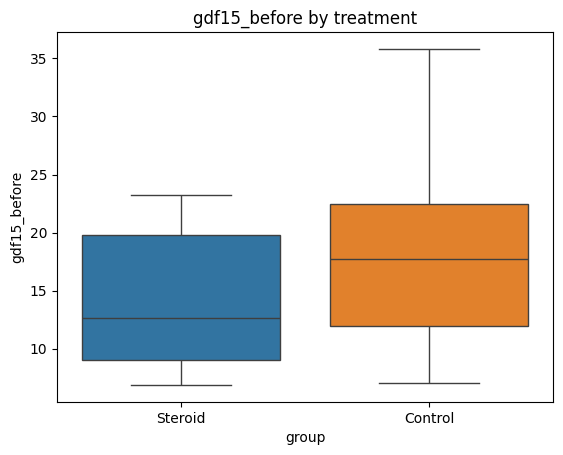

In [33]:
# GDF15 Before
dist_boxplot(data_update, 'gdf15_before')

In [34]:
perform_statistical_tests(data_update, 'group', 'gdf15_before', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.14584112788487083
Shapiro-Wilk test for Control (n=11): p-value = 0.563749602961911
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.2540068462574645, p-value = 0.22429925452130164
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.2540068462574645, p-value = 0.2260070517631878


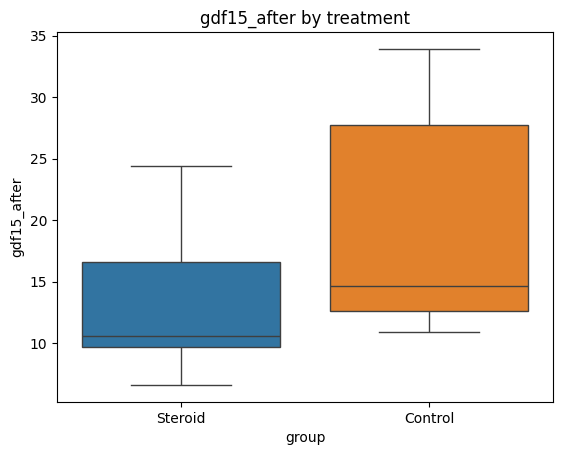

In [39]:
# GDF15 After
dist_boxplot(data_update, 'gdf15_after')

In [40]:
perform_statistical_tests(data_update, 'group', 'gdf15_after', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.19874159077805015
Shapiro-Wilk test for Control (n=11): p-value = 0.02189256856196692
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=11 vs. n=11): U-statistic = 29.0, p-value = 0.04178899680298453


In [41]:
# Function to test for Statistical Significance in Difference between Sample Means
def perform_t_test(data, group_column, value_column, group1, group2):
    """
    Perform statistical tests (normality tests and t-tests or Mann-Whitney U tests) between two groups.

    Parameters:
    - data: DataFrame containing the data.
    - group_column: Column name indicating the group (e.g., 'Race').
    - value_column: The column containing the values to test (e.g., 'IGFBP7').
    - group1: The first group to compare (e.g., 'black').
    - group2: The second group to compare (e.g., 'white').
    """
    # Filter and remove NaN values for both groups
    group1_data = data[data[group_column] == group1][value_column].dropna()
    group2_data = data[data[group_column] == group2][value_column].dropna()

    # Check the sample size
    if len(group1_data) < 3 or len(group2_data) < 3:
        print(f"Not enough data for statistical testing. {group1}: {len(group1_data)}, {group2}: {len(group2_data)}")
        return   
        
    # Perform Independent t-test (assuming equal variances)
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
    print(f"Independent t-test result (n={len(group1_data)} vs. n={len(group2_data)}): t-statistic = {t_stat}, p-value = {p_value}")
   

In [38]:
perform_t_test(data_update, 'group', 'gdf15_after', 'Steroid', 'Control')

Independent t-test result (n=11 vs. n=11): t-statistic = -1.989625554297901, p-value = 0.06048177525960365


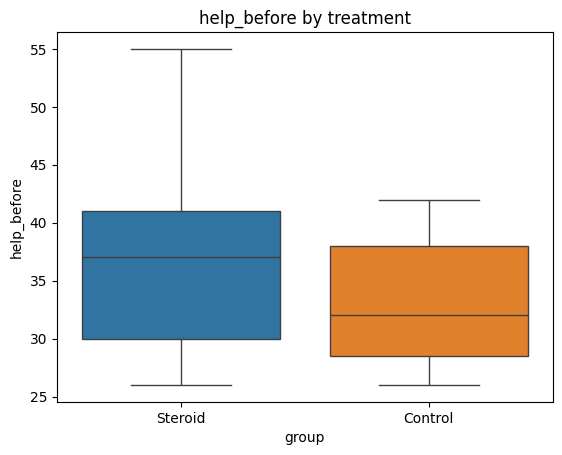

In [42]:
# HELP Before
dist_boxplot(data_update, 'help_before')

In [43]:
perform_statistical_tests(data_update, 'group', 'help_before', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.4697594148248439
Shapiro-Wilk test for Control (n=11): p-value = 0.09942919916614272
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = 1.1953810004112362, p-value = 0.24592031851207333
Welch's t-test result (n=11 vs. n=11): t-statistic = 1.1953810004112362, p-value = 0.24727665370254676


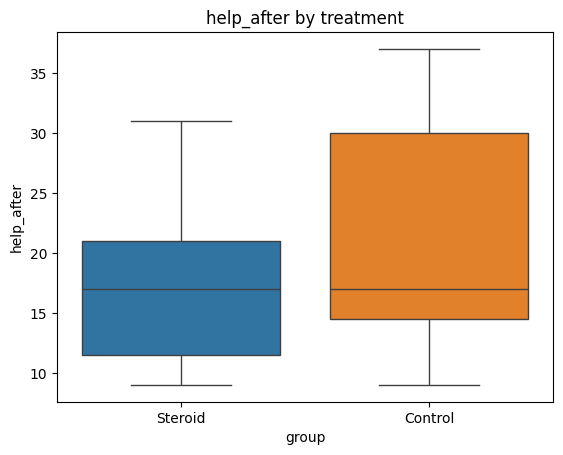

In [44]:
# HELP After
dist_boxplot(data_update, 'help_after') 

In [45]:
perform_statistical_tests(data_update, 'group', 'help_after', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.2742526570383335
Shapiro-Wilk test for Control (n=11): p-value = 0.15188862750054813
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.152523909604337, p-value = 0.26269590490412376
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.152523909604337, p-value = 0.2634302272307022


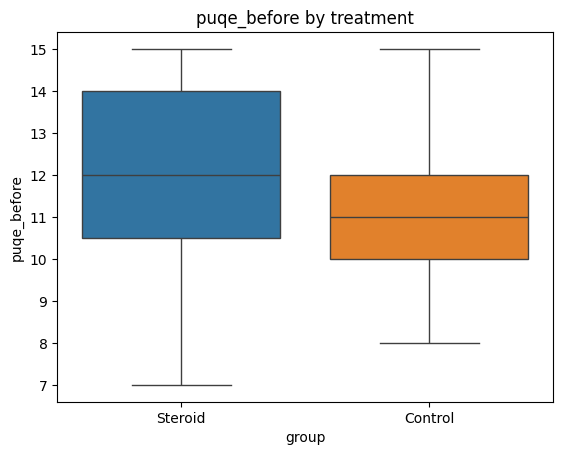

In [46]:
# PUQE Before
dist_boxplot(data_update, 'puqe_before') 

In [47]:
perform_statistical_tests(data_update, 'group', 'puqe_before', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.4370161633950503
Shapiro-Wilk test for Control (n=11): p-value = 0.2960892713267498
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = 0.43453624965687265, p-value = 0.6685512837831329
Welch's t-test result (n=11 vs. n=11): t-statistic = 0.43453624965687265, p-value = 0.6687347035869255


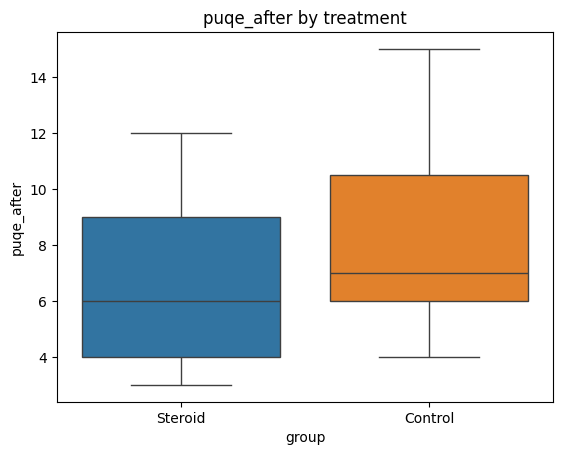

In [48]:
# PUQE After
dist_boxplot(data_update, 'puqe_after') 

In [49]:
perform_statistical_tests(data_update, 'group', 'puqe_after', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.30144320040462214
Shapiro-Wilk test for Control (n=11): p-value = 0.5237682126377838
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.229880092536182, p-value = 0.2330137295841764
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.229880092536182, p-value = 0.2331291750466861


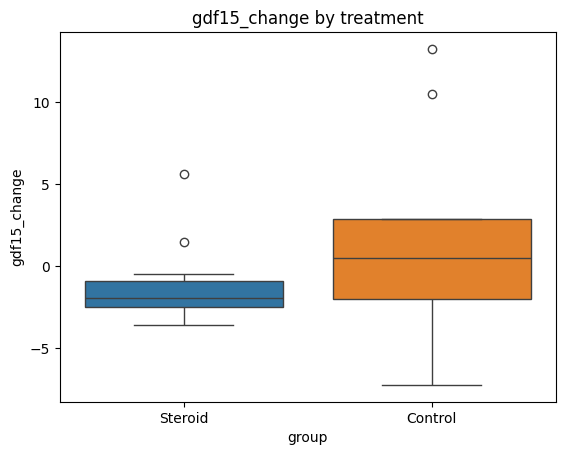

In [54]:
# GDF15 Change
dist_boxplot(data_update, 'gdf15_change') 

In [52]:
perform_statistical_tests(data_update, 'group', 'gdf15_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.009186530312759173
Shapiro-Wilk test for Control (n=11): p-value = 0.40175209331412476
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=11 vs. n=11): U-statistic = 42.0, p-value = 0.23721752775378102


In [53]:
perform_t_test(data_update, 'group', 'gdf15_change', 'Steroid', 'Control')

Independent t-test result (n=11 vs. n=11): t-statistic = -1.2696682935954942, p-value = 0.21877798550867633


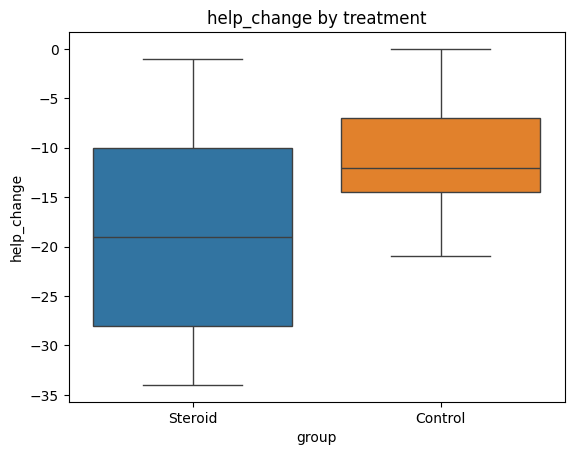

In [64]:
# HELP Change
dist_boxplot(data_update, 'help_change') 

In [65]:
perform_statistical_tests(data_update, 'group', 'help_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.581434555322151
Shapiro-Wilk test for Control (n=11): p-value = 0.8091791193681913
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -2.0502679825817562, p-value = 0.05367650813596159
Welch's t-test result (n=11 vs. n=11): t-statistic = -2.0502679825817562, p-value = 0.05726909246675122


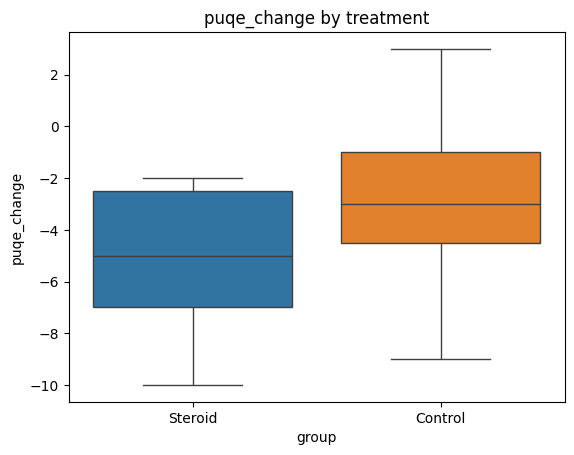

In [67]:
# PUQE Change
dist_boxplot(data_update, 'puqe_change') 

In [68]:
perform_statistical_tests(data_update, 'group', 'puqe_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 0.3382294528445681
Shapiro-Wilk test for Control (n=11): p-value = 0.7626719947485254
Both groups are normally distributed. Performing t-tests.
Independent t-test result (n=11 vs. n=11): t-statistic = -1.5955303305205966, p-value = 0.12627470013414477
Welch's t-test result (n=11 vs. n=11): t-statistic = -1.5955303305205966, p-value = 0.12694034104474855


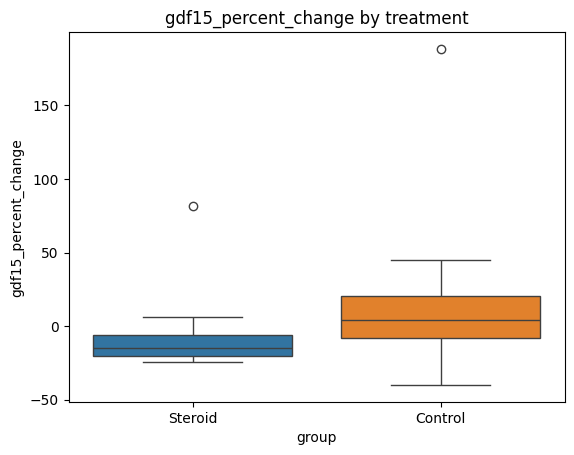

In [69]:
# GDF15 Percent Change
dist_boxplot(data_update, 'gdf15_percent_change') 

In [70]:
perform_statistical_tests(data_update, 'group', 'gdf15_percent_change', 'Steroid', 'Control')

Shapiro-Wilk test for Steroid (n=11): p-value = 4.945807184749589e-05
Shapiro-Wilk test for Control (n=11): p-value = 0.0006811146463075098
At least one group is not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U test result (n=11 vs. n=11): U-statistic = 39.0, p-value = 0.16790547565263503
